In [1]:
import sys
sys.path.append('/Users/mgehan/Documents/github/plantcv/')

In [2]:
# STEP 1: Import package code
%matplotlib inline
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import plantcv as pcv
from plantcv.dev.color_palette import color_palette

/Users/mgehan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# STEP 2: Set global variables
device = 0                                                          # Workflow step counter
debug = 'print'                                                      # Plot debug images to the notebook
rgb_img = './examples/multi-plant-images/cam14-16-08-05_19:15.jpg'  # Image filename

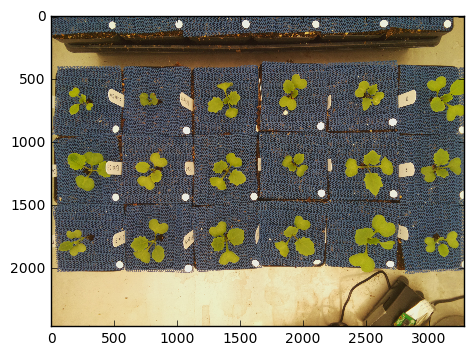

In [4]:
# STEP 3: Read RGB image and plot it to the notebook
# Inputs:
#    filename = name of image file
img, path, filename = pcv.readimage(rgb_img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
# Step 4: Check if this is a night image, for some of these datasets images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the pipeline.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass

In [6]:
# Step 5: Normalize the white color so you can later
# compare color between images.
# Inputs:
# device = device number. Used to count steps in the workflow
# img = image object, RGB colorspace
# debug = None, print, or plot. Print = save to file, Plot = print to screen.
# roi = region for white reference, if none uses the whole image,
# otherwise (x position, y position, box width, box height)

#white balance image based on white toughspot
device,img1=pcv.white_balance(device,img,debug,roi=(400,800,200,200))

In [7]:
device, rotate_img = pcv.rotate_img(img1, -1, device, debug)


In [8]:
#Step 6: Shift image. This step is important for clustering later on.
# For this image it also allows you to push the green raspberry pi camera
# out of the image. This step might not be necessary for all images.
# The resulting image is the same size as the original.
# Input:
# img = image object
# device = device number. Used to count steps in the workflow
# number = integer, number of pixels to move image
# side = direction to move from "top", "bottom", "right","left"
# debug = None, print, or plot. Print = save to file, Plot = print to screen.

device, shift1 = pcv.shift_img(img1, device, 300, 'top', debug)
img1 = shift1

In [9]:
# STEP 7: Convert image from RGB colorspace to LAB colorspace
# Keep only the green-magenta channel (grayscale)
# Inputs:
#    img     = image object, RGB colorspace
#    channel = color subchannel (l = lightness, a = green-magenta , b = blue-yellow)
#    device  = device number. Used to count steps in the workflow
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, a = pcv.rgb2gray_lab(img1, 'a', device, debug)

In [10]:
# STEP 8: Set a binary threshold on the Saturation channel image
# Inputs:
#    img         = img object, grayscale
#    threshold   = threshold value (0-255)
#    maxValue    = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#                  - If object is light then standard thresholding is done
#                  - If object is dark then inverse thresholding is done
#    device      = device number. Used to count steps in the pipeline
#    debug       = None, print, or plot. Print = save to file, Plot = print to screen.
device, img_binary = pcv.binary_threshold(a, 120, 255, 'dark', device, debug)
#                                            ^
#                                            |
#                                           adjust this value

In [11]:
# STEP 9: Fill in small objects (speckles)
# Inputs:
#    img    = image object, grayscale. img will be returned after filling
#    mask   = image object, grayscale. This image will be used to identify contours
#    size   = minimum object area size in pixels (integer)
#    device = device number. Used to count steps in the pipeline
#    debug  = None, print, or plot. Print = save to file, Plot = print to screen.
mask = np.copy(img_binary)
device, fill_image = pcv.fill(img_binary, mask, 100, device, debug)
#                                               ^
#                                               |
#                                               adjust this value

In [12]:
# STEP 10: Dilate so that you don't lose leaves (just in case)
# Inputs:
#    img     = input image
#    kernel  = integer
#    i       = interations, i.e. number of consecutive filtering passes
#    device  = device number. Used to count steps in the pipeline
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.

device, dilated = pcv.dilate(fill_image, 1, 1, device, debug)


In [13]:
# STEP 11: Find objects (contours: black-white boundaries)
# Inputs:
#    img       = image that the objects will be overlayed
#    mask      = what is used for object detection
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
device, id_objects, obj_hierarchy = pcv.find_objects(img1, dilated, device, debug)

In [14]:
# STEP 12: Define region of interest (ROI)
# Inputs:
#    img       = img to overlay roi
#    roi       = default (None) or user input ROI image, object area should be white and background should be black,
#                has not been optimized for more than one ROI
#    roi_input = type of file roi_base is, either 'binary', 'rgb', or 'default' (no ROI inputted)
#    shape     = desired shape of final roi, either 'rectangle' or 'circle', if  user inputs rectangular roi but chooses
#                'circle' for shape then a circle is fitted around rectangular roi (and vice versa)
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
#    adjust    = either 'True' or 'False', if 'True' allows user to adjust ROI
#    x_adj     = adjust center along x axis
#    y_adj     = adjust center along y axis
#    w_adj     = adjust width
#    h_adj     = adjust height
device, roi, roi_hierarchy = pcv.define_roi(img1, 'rectangle', device, None, 'default', debug, True, 
                                             10, 500, -10, -100)
#                                            ^                ^
#                                            |________________|
#                                            adjust these four values

In [15]:
 # STEP 13: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction
#    device         = device number.  Used to count steps in the pipeline
#    debug          = None, print, or plot. Print = save to file, Plot = print to screen.
device, roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img1, 'partial', roi, roi_hierarchy,
                                                                           id_objects, obj_hierarchy, device,
                                                                           debug)


In [16]:
#Step 14: This function take a image with multiple contours and 
# clusters them based on user input of rows and columns

#Inputs:
#    img - An RGB image array
#    roi_objects - object contours in an image that are needed to be clustered.
#    nrow - number of rows to cluster (this should be the approximate  number of desired rows in the entire image (even if there isn't a literal row of plants)
#    ncol - number of columns to cluster (this should be the approximate number of desired columns in the entire image (even if there isn't a literal row of plants)
#    file -  output of filename from read_image function
#    filenames - input txt file with list of filenames in order from top to bottom left to right
#    debug - print debugging images

device, clusters_i, contours = pcv.cluster_contours(device, img1, roi_objects, 4, 6, debug)


In [17]:
#Step 15:This function takes clustered contours and splits them into multiple images, 
#also does a check to make sure that the number of inputted filenames matches the number
#of clustered contours. If no filenames are given then the objects are just numbered

#Inputs:
#    img - ideally a masked RGB image.
#    grouped_contour_indexes - output of cluster_contours, indexes of clusters of contours
#    contours - contours to cluster, output of cluster_contours
#    file -  the name of the input image to use as a base name , output of filename from read_image function
#    filenames - input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)
#    debug - print debugging images
    
out = './examples/multi-plant-images/multi-output/'
names = './examples/multi-plant-images/cam14.txt'
device, output_path = pcv.cluster_contour_splitimg(device, img1, clusters_i, contours, out, filename, names,
                                                       debug)

In [18]:
# Now you have a folder of images with individual plants and you can process them (additional pipeline)
# like you would with any individual plants